# petitRADTRANS, low and high resolution forward models, retrievals from low resolution spectra

*Eleonora Alei & Evert Nasedkin*


petitRADTRANS (pRT) is a Python package for calculating transmission and emission spectra of exoplanets for clear and cloudy planets. pRT also incorporates an easy subpackage for running retrievals with nested sampling.

The majority of this lecture is taken from the official [documentation](https://petitradtrans.readthedocs.io/en/latest/index.html). There are however some new, interactive exercises for you to run. 

We probably won't have time to go through all of the interactive exercises, but feel free to play with it and share some results with us in the Slack channel [#petitradtrans](https://esoexoplaneta-i9v3231.slack.com/archives/C02BRJ7UL1J). This channel will also be used to discuss questions that you may have (remember to tag the lecturers with @)

Now, the first step: copy this repository into your Google Drive! Click File > Save a copy in Drive.



# Installation

Let's install the useful packages and download the data. This will take a few minutes, so please run the cell at the very beginning of the lecture.

*The data we are going to download is a reduced set of opacities that is going to be useful purely for the purpose of this lecture. For the default opacities, check the [installation docs](https://petitradtrans.readthedocs.io/en/latest/content/installation.html).*
*You can also add your own opacities by following [this tutorial](https://petitradtrans.readthedocs.io/en/latest/content/opa_add.html).*

In [ ]:
!git clone https://github.com/JohannesBuchner/MultiNest.git
%cd /content/MultiNest/build
!pwd
!cmake .. 
!make
!cp /content/MultiNest/lib/* /usr/lib/
%cd /content/
!pip install pymultinest
!wget -O input_data_red.tar.gz "https://polybox.ethz.ch/index.php/s/V3uTstd8pya6swr/download"
!tar -xzf input_data_red.tar.gz --warning=no-unknown-keyword
!pip install petitradtrans
!git clone https://gitlab.com/mauricemolli/petitRADTRANS.git

Cloning into 'MultiNest'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 541 (delta 61), reused 41 (delta 15), pack-reused 431
Receiving objects: 100% (541/541), 290.77 KiB | 7.65 MiB/s, done.
Resolving deltas: 100% (338/338), done.
/content/MultiNest/build
/content/MultiNest/build
-- The Fortran compiler identification is GNU 7.5.0
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working Fortran compiler: /usr/bin/f95
-- Check for working Fortran compiler: /usr/bin/f95  -- works
-- Detecting Fortran compiler ABI info
-- Detecting Fortran compiler ABI info - done
-- Checking whether /usr/bin/f95 supports Fortran 90
-- Checking whether /usr/bin/f95 supports Fortran 90 -- yes
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compil

Alright! We're ready to get started!

##Importing the libraries 

Let's specify the path to the input data folder and then import `petitRADTRANS`.





In [ ]:
# Other useful libraries
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

import os
from IPython.display import display
import ipywidgets as widgets

# petitRADTRANS-related libraries 
os.environ["pRT_input_data_path"] = "/content/input_data"
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
import petitRADTRANS.retrieval.plot_style

Using pRT Plotting style!


#Defining a Radtrans object

The first thing to be done is to create an instance of the radiative transfer object.

Here, we want to load the opacities of Na between 0.5 an 0.6 micron. 

In [ ]:
# K-CORRELATED 
atmosphere_kcorr = Radtrans(line_species = ['Na_allard'],
                      wlen_bords_micron = [0.5, 0.6])


This will by default consider the 'low-resolution' opacities as k-correlated tables at resolution R=$\frac{\lambda}{\Delta\lambda}$ = 1000. `petitRADTRANS` can also work with 'high-resolution' line-by-line opacities: this mode can be activated by specifying `mode = 'lbl'` when declaring the `Radtrans` object.

For more info on correlated-k versus line-by-line, see e.g. [Fu&Liou 1992](https://journals.ametsoc.org/view/journals/atsc/49/22/1520-0469_1992_049_2139_otcdmf_2_0_co_2.xml).


*(We will compare the two modes at the end of the first section.)*



In [ ]:
# LINE BY LINE
atmosphere_lbl = Radtrans(line_species = ['Na'],
                      wlen_bords_micron = [0.5, 0.6],
                      mode = 'lbl')



The `_HITEMP` and `_allard` identifiers stand for different line lists, or line broadening treatments. 

**IMPORTANT!** If you are using the standard `petitRADTRANS` opacities, you must follow a specific notation to import them. For more information, visit the documentation link [Available opacity species](https://petitradtrans.readthedocs.io/en/latest/content/available_opacities.html).

---

Let's create a more complicated `Radtrans` object. Here we ask for the following molecular or atomic line absorbers to be inlcuded: 
H$_2$O, CO, CH$_4$, CO$_2$, Na, and K. Additionally, the Rayleigh scattering cross-sections for H$_2$ and He were loaded, as well as the collision induced absorption (CIA) cross-sections for the H$_2$-H$_2$ and H$_2$-He pairs. The wavelength range that was loaded for the opacities here extends from 0.3 to 15 microns.

In [ ]:
atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CO_all_iso_HITEMP',
                                      'CH4',
                                      'CO2',
                                      'Na_allard',
                                      'K_allard'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.3, 15])

  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



## Defining the pressure-temperature profile

Now, let’s define the pressures of the atmospheric layers. Note that the pressures must always be sorted in increasing order, and be equidistant in log-space. Typically include of the order of 100 layers in your computations.

Then, assign the pressure array to the atmosphere object.

**IMPORTANT!** All units in petitRADTRANS are in cgs, except for pressure, which is in bars, and the mean molecular weight (MMW), which is in units of atomic mass units.


In [ ]:
pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)

We can then create the temperature profile. We need to have the temperature values corresponding to the pressure points that we have defined. These can come from data or be calculated from a function. 
In this example, we have created a function (*not mandatory*) that allows to get different temperature profiles using different models (isothermal, guillot, polynomial), the array of pressures, and arguments specific of the chosen model.


In this case:

1. The **isothermal** profile is a constant temperature profile. 

2. The **Guillot** profile follows this equation (see [Eq. 29 from Guillot (2010)](http://adsabs.harvard.edu/abs/2010A%26A...520A..27G) for a more general case):
\begin{equation}
T^4 = \frac{3T_{\rm int}^4}{4}\left(\frac{2}{3}+\tau\right) + \frac{3}{4} T_{\rm eq}^4\left[\frac{2}{3}+\frac{1}{\gamma\sqrt{3}}+\left(\frac{\gamma}{\sqrt{3}}-\frac{1}{\gamma\sqrt{3}}\right)e^{-\gamma\tau\sqrt{3}}\right]
\end{equation}
with $\tau = P\kappa_{\rm IR}/g$. Here, $\tau$ is the optical depth, $P$ the pressure, $\kappa_{\rm IR}$ is the atmospheric opacity in the IR wavelengths (i.e. the cross-section per unit mass), $\gamma$ is the ratio between the optical and IR opacity, $T_{\rm equ}$ the atmospheric equilibrium temperature, and $T_{\rm int}$ is the planetary internal temperature.

 It is included in the `nat_cst`=`nc` module that comes with `petitRADTRANS`. 

3. The **polynomial** profile is a polynomial function.


*For the purposes of the lecture we have defined a function that fills up the array, but the model works just as well without it.*

Text(0, 0.5, 'P [bar]')

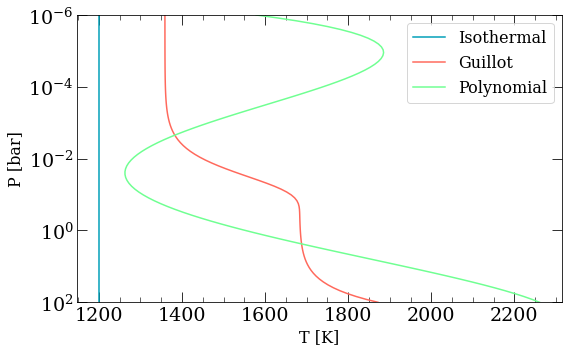

In [ ]:
def pT_profile_creator(key = 'isothermal',
                       pressures = pressures,
                       T_iso = 1200, # isothermal default parameter
                       kappa_IR = 0.01, gamma = 0.4, T_int = 200., T_equ = 1500., gravity = 10**2.45, # guillot default parameters
                       coeffs = [-4.28,-23.25,71.62,337.93,1552.64]): # polynomial default parameter
  
  if key == 'isothermal': # Constant temperature over all pressure layers
    temperature = T_iso * np.ones_like(pressures)
  if key == 'guillot': # Guillot profile (included in pRT) [Guillot2010]
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
  if key == 'polynomial': #polynomial. The more coefficients, the higher the degree. Order: a_n to a_0 for an n+1 order polynomial
    temperature = np.polyval(coeffs, np.log10(pressures))

  return temperature


# CALLING THE FUNCTION
temperature_iso = pT_profile_creator(key = 'isothermal', pressures = pressures, T_iso = 1200.)
temperature_guil = pT_profile_creator(key = 'guillot', pressures = pressures, kappa_IR = 0.01, gamma = 0.4, T_int = 200., T_equ = 1500., gravity = 10**2.45)
temperature_poly = pT_profile_creator(key = 'polynomial', pressures = pressures, coeffs = [ -4.28, -23.25, 71.62, 337.93, 1552.64])


# PLOTTING
%matplotlib inline
fig,ax = plt.subplots(figsize = (8,5))
ax.plot(temperature_iso, pressures,label = 'Isothermal')
ax.plot(temperature_guil, pressures,label = 'Guillot')
ax.plot(temperature_poly, pressures,label = 'Polynomial')

ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.legend(fontsize = 16)
ax.set_xlabel('T [K]',fontsize = 16)
ax.set_ylabel('P [bar]',fontsize = 16)
 


##Defining the chemical composition

Now, we need to define the abundance dictionary, containing the **mass fractions** of the atmospheric material, at every layer, and the atmospheric mean molecular weight, at every layer, in units of amu. 

**IMPORTANT!** Abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). You can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the mass of a single molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molecular weight, and $n_i$ is the VMR of species $i$. There are several utility functions defined in `petitRADTRANS.retrieval.util` to convert between mass and number fraction abundances [(see here)](https://petitradtrans.readthedocs.io/en/latest/autoapi/petitRADTRANS/retrieval/util/index.html#petitRADTRANS.retrieval.util.mass_to_number).

*Again, for the purposes of the lecture we have defined a function that fills up the array, but the model works just as well without it.*



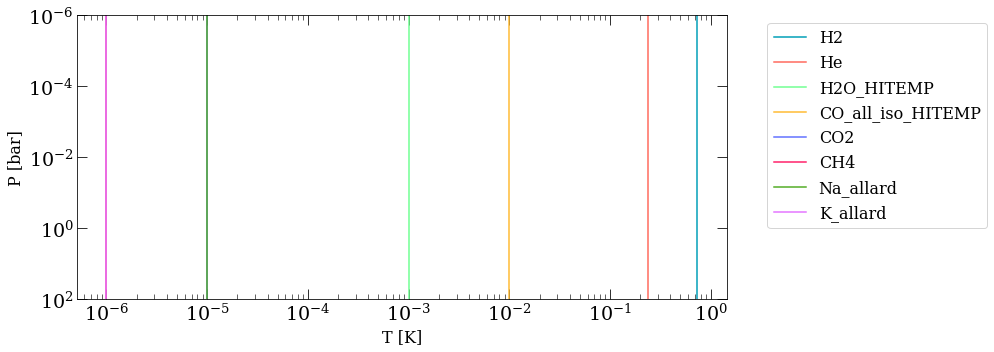

In [ ]:
def mass_fractions_creator(temperature):
  # it works with any array that has the shape of the temperature/pressure array [the values in the array don't play a role]
  mass_fractions = {}
  mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
  mass_fractions['He'] = 0.24 * np.ones_like(temperature)
  mass_fractions['H2O_HITEMP'] = 0.001 * np.ones_like(temperature)
  mass_fractions['CO_all_iso_HITEMP'] = 0.01 * np.ones_like(temperature)
  mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)
  mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)
  mass_fractions['Na_allard'] = 0.00001 * np.ones_like(temperature)
  mass_fractions['K_allard'] = 0.000001 * np.ones_like(temperature)

  MMW = 2.33 * np.ones_like(temperature)
  return mass_fractions, MMW


# CALLING THE FUNCTION
mass_fractions, MMW = mass_fractions_creator(temperature_iso) 


# PLOTTING
%matplotlib inline
fig,ax = plt.subplots(figsize = (14,5))

for species in mass_fractions.keys():
  ax.plot(mass_fractions[species], pressures, label = species)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e2, 1e-6])
ax.legend(bbox_to_anchor = (1.05, 1), fontsize = 16 )
ax.set_xlabel('T [K]', fontsize = 16)
ax.set_ylabel('P [bar]', fontsize = 16)
plt.show()


**Note that these are freely made up values, however. The P-T profile of a real planet may well be different, and not isothermal. Also the abundances are just made up for this simple example here** (see ["Interpolating chemical equilibrium abundances"](https://petitradtrans.readthedocs.io/en/latest/content/notebooks/poor_man.html) for how to improve this.)

#Calculating a transmission spectrum

Once the `Radtrans` object is declared, the pressure-temperature profile set up and initialized, and the abundances and MMW determined, we can declare  a planetary radius and gravity at a given pressure 
$P_0=0.01\ bar$ in the atmosphere. 

**IMPORTANT!** the module `nat_cst`=`nc` that we included contains many useful constants already in cgs. See [nat_cst constants](https://petitradtrans.readthedocs.io/en/latest/content/nat_cst_doc.html) for more info.


**IMPORTANT!** For the sake of time, we are neglecting clouds in the calculation. See [Including clouds](https://petitradtrans.readthedocs.io/en/latest/content/notebooks/clouds.html) from the official documentation to see how it's done.


We can then produce a transmission spectrum using the built-in function `calc_transm`.

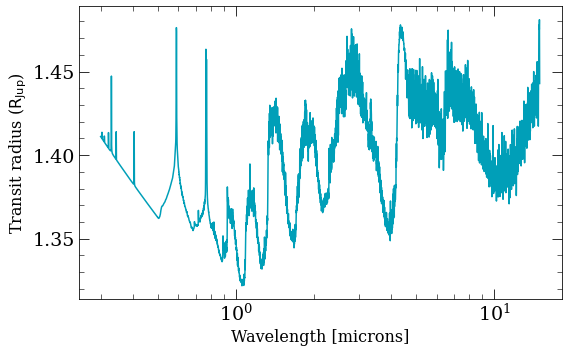

In [ ]:
# DECLARING THE VARIABLES
R_pl = 1.382 * nc.r_jup_mean
gravity = 1e1**2.45
P0 = 0.01

# PRODUCING THE SPECTRUM
atmosphere.calc_transm(temperature_iso, mass_fractions, gravity, MMW, R_pl = R_pl, P0_bar = P0)

# PLOTTING
%matplotlib inline
fig,ax = plt.subplots(figsize = (8,5))
ax.plot(nc.c/atmosphere.freq/1e-4, atmosphere.transm_rad/nc.r_jup_mean)
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]', fontsize = 16)
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)', fontsize = 16)
plt.show()    

### Exercise: let's play with the variables 

We have implemented the previous code in a function, to allow you to work interactively. You can change the radius of the planet (in Jupiter Masses), the gravity (in cm/s$^{2}$) at $P_0$, and the temperature of the isothermal profile (in K).

Questions:


1.  What happens to the transmission spectrum if we change the radius of the planet, keeping the gravity fixed?
2.   What happens to the transmission spectrum if we change the gravity, keeping the radius fixed?
3. What happens to the transmission spectrum if we change the isothermal temperature (not more than 3000 K for visibility purposes)?



In [ ]:
def transm_spectrum(R_pl = 1.838,gravity = 10**2.45,T_iso = 1200.):

  # DEFINING THE PRESSURE
  pressures = np.logspace(-6, 2, 100)
  atmosphere.setup_opa_structure(pressures)

  # DEFINING THE TEMPERATURE PROFILE
  temperature = pT_profile_creator(key = 'isothermal', pressures = pressures, T_iso = float(T_iso))

  # DEFINING THE ABUNDANCES
  mass_fractions, MMW = mass_fractions_creator(temperature) 
  
  # DECLARING THE RADIUS
  R_pl = float(R_pl) * nc.r_jup_mean
  P0 = 0.01
  
  # CALCULATE SPECTRUM (given the data)
  atmosphere.calc_transm(temperature, mass_fractions, float(gravity), MMW, R_pl = R_pl, P0_bar = P0)
  
  # PLOTTING
  %matplotlib inline
  fig,ax = plt.subplots(figsize = (8,5))

  ## Plot the old spectra (if any)
  for i in np.arange(0, len(tran_old)):
        plt.plot(nc.c/atmosphere.freq/1e-4, tran_old[i])

  ## Save the spectrum in the old spectra list
  tran_old.append(atmosphere.transm_rad/nc.r_jup_mean)

  ## Plot the current spectrum  
  ax.plot(nc.c/atmosphere.freq/1e-4, atmosphere.transm_rad/nc.r_jup_mean)
  
  ax.set_xscale('log')
  plt.xlabel('Wavelength [microns]', fontsize = 16)
  plt.ylabel(r'Transit radius ($\rm R_{Jup}$)', fontsize = 16)
    
# INTERACTIVE WIDGET
tran_old = []
widgets.interact_manual(transm_spectrum, R_pl = '1.838', gravity = '282', T_iso = '1200', continuous_update = False)


interactive(children=(Text(value='1.838', description='R_pl'), Text(value='282', description='gravity'), Text(…

<function __main__.transm_spectrum>

# Calculating an emission spectrum


Using another built-in function `calc_flux` we can produce an emission spectrum at the top of the atmosphere.


**IMPORTANT!** the module `nat_cst`=`nc` that we included contains many useful constants already in cgs. See [nat_cst constants](https://petitradtrans.readthedocs.io/en/latest/content/nat_cst_doc.html) for more info.


**IMPORTANT!** Scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](https://petitradtrans.readthedocs.io/en/latest/content/emis_scat.html) for an example how to do this). We neglect the scattering here.



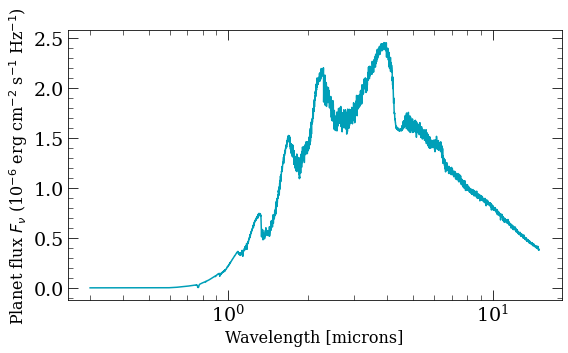

In [ ]:
# PRODUCING THE SPECTRUM
atmosphere.calc_flux(temperature_guil, mass_fractions, gravity, MMW)

# PLOTTING
%matplotlib inline
fig,ax = plt.subplots(figsize = (8,5))
ax.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6)  
ax.set_xscale('log')
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]', fontsize = 16)
ax.set_ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)', fontsize = 16)
plt.show()

### Exercise: let's play with the variables 

We have implemented the previous code in a function, to allow you to work interactively. You can change the p-T profile keyword (`isothermal`, `guillot`, `polynomial`; the default parameters will be used) and the gravity (in cm/s$^2$).

Questions:

1.   What happens to the emission spectrum if we change the gravity, keeping the p-T profile fixed?
2. What happens to the emission spectrum if we change the p-T profile, keeping the gravity fixed?




In [ ]:
def emis_spectrum(profile = 'guillot', gravity = 10**2.45):
  
  # DEFINING THE PRESSURE
  pressures = np.logspace(-6, 2, 100)
  atmosphere.setup_opa_structure(pressures)

  # DEFINING THE TEMPERATURE PROFILE
  temperature = pT_profile_creator(key = profile, pressures = pressures)

  # DEFINING THE ABUNDANCES
  mass_fractions, MMW = mass_fractions_creator(temperature) 
  
  # DECLARING THE RADIUS
  R_pl = 1.838 * nc.r_jup_mean
  
  # CALCULATE SPECTRUM (given the data)
  atmosphere.calc_flux(temperature, mass_fractions, float(gravity), MMW)

  # PLOTTING
  %matplotlib inline
  fig,ax = plt.subplots(figsize = (8,5))

  ## Plot the old spectra (if any)
  for i in np.arange(0, len(emis_old)):
        plt.plot(nc.c/atmosphere.freq/1e-4, emis_old[i])

  ## Save the spectrum in the old spectra list
  emis_old.append(atmosphere.flux/1e-6)

  ## Plot the current spectrum  
  ax.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6)
  
  ax.set_xscale('log')
  plt.xlabel('Wavelength [microns]', fontsize = 16)
  plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)', fontsize = 16)
  
# INTERACTIVE WIDGET
emis_old = []
widgets.interact_manual(emis_spectrum, profile = ['guillot','polynomial','isothermal'], gravity = '282', continuous_update = False)

interactive(children=(Dropdown(description='profile', options=('guillot', 'polynomial', 'isothermal'), value='…

<function __main__.emis_spectrum>

#Comparing high-resolution and low-resolution

We have seen how `petitRADTRANS` can work both in high-resolution mode (using the line-by-line radiative transfer calculation) and low-resolution mode (using the correlated-k radiative transfer calculation). For more info on the correlated-k, see e.g. [Fu&Liou 1992](https://journals.ametsoc.org/view/journals/atsc/49/22/1520-0469_1992_049_2139_otcdmf_2_0_co_2.xml).

Let's compare high-resolution and low-resolution by producing a transmission spectrum of an Hot Jupiter near the Na-doublet region.

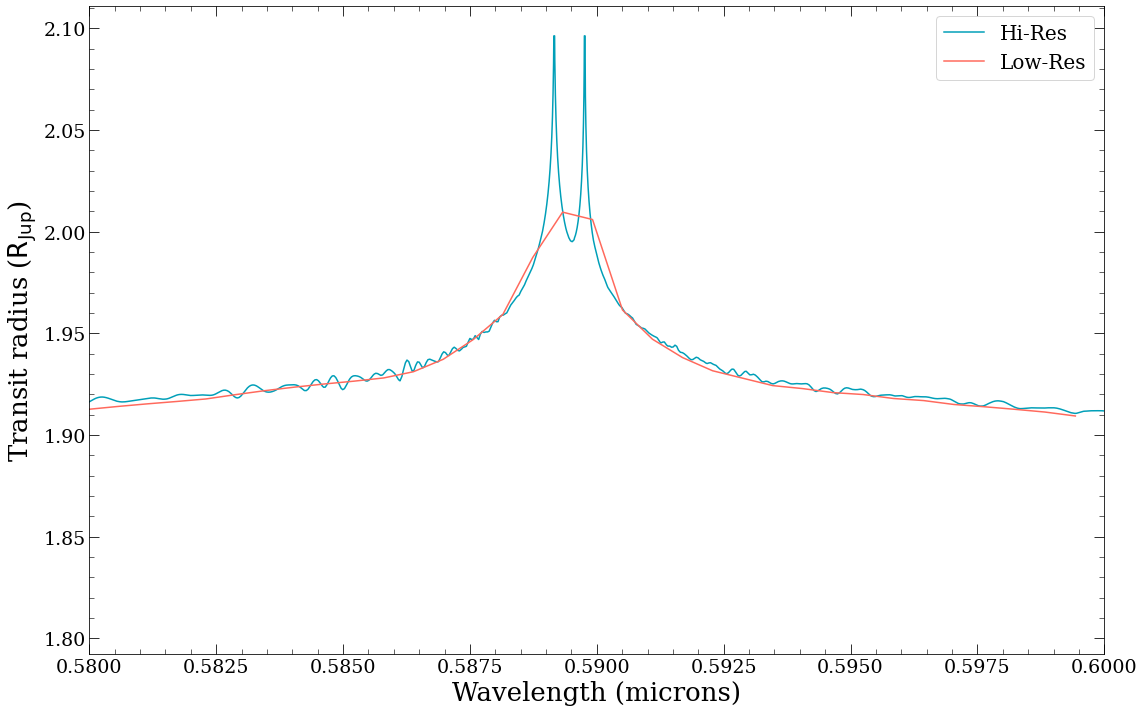

In [ ]:
# DEFINING THE PRESSURE
pressures = np.logspace(-6, 2, 100)
atmosphere_lbl.setup_opa_structure(pressures)
atmosphere_kcorr.setup_opa_structure(pressures)

# DECLARING THE VARIABLES
R_pl = 1.838 * nc.r_jup_mean
gravity = 1e1**2.45
P0 = 0.01

# DEFINING THE TEMPERATURE PROFILE (here we are doing it without calling the pt_profile_creator function to show you that it can be done easily)
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.
temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

# DEFINING THE ABUNDANCES (here we are doing it without calling the mass_fractions_creator function to show you that it can be done easily)
mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['Na'] = 0.001 * np.ones_like(temperature)
mass_fractions['Na_allard'] = 0.001 * np.ones_like(temperature)

MMW = 2.33 * np.ones_like(temperature)

# CALCULATING THE TRANSMISSION SPECTRA
atmosphere_lbl.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl = R_pl, P0_bar = P0)
atmosphere_kcorr.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl = R_pl, P0_bar = P0)

# PLOTTING
%matplotlib inline
fig,ax = plt.subplots(figsize = (16,10))
plt.plot(nc.c/atmosphere_lbl.freq/1e-4, atmosphere_lbl.transm_rad/nc.r_jup_mean, label = 'Hi-Res')
plt.plot(nc.c/atmosphere_kcorr.freq/1e-4, atmosphere_kcorr.transm_rad/nc.r_jup_mean, label = 'Low-Res')

ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.set_xlim(0.58,0.6)
ax.legend()
plt.show()

The high-resolution spectrum makes the Na-doublet visible, while the low-resolution spectrum doesn't. So, make sure to use `petitRADTRANS` in the right mode depending on what you need! 

---

# Atmospheric Retrievals

An atmospheric retrieval is inverse problem of modelling - that is, we want to identify and measure the atmospheric parameters that describe a real atmosphere.

To do this we need three things: 
1. Measurements of an atmosphere, usually in the form of a spectrum,
2. an atmospheric model that describes the chemistry, dynamics and radiative transfer throughout the atmosphere, and 
3. a sampler which can explore the parameter space and find the set of model parameters that will best fit the data, typically using some likelihood function as a measure of goodness-of-fit. Usually the sampler will also produce the posterior distributions of these parameters, as well as the Bayesian evidence which allows us to compare different models.

In this example, we'll walk through how to set up and run a retrieval using petitRADTRANS, as well as explore fitting data by hand to get a sense of how the retrieval works.

## Background: Bayesian Statistics

Atmospheric retrievals are based within a Bayesian statistics framework. This means we use Bayes theorem to find the **posterior probability** of a model ($H$) given the data ($D$):
\begin{equation}
  P(H|D) = \frac{P(D|H)\cdot P(H)}{P(D)}
\end{equation}
This is weighted by the **prior probability**, $P(H)$, which reflects our prior knowledge about the system - knowing a reasonable temperature regime for the planet's atmosphere, for example. We use a sampler to find the **likelihood** $P(D|H)$, which is the probability of observing the data, given the model. **The goal of the retrieval is to minimize the likelihood function, and compute the posterior distributions of the model.**


## Setting up a model
First, we need to set up a model to describe our atmosphere. The model you choose is highly dependant on your planet and what assumptions are reasonable. For example, are you looking at a planet in transmission or emission? What temperature regime does your planet fall under - is chemical equilibrium reaonable? Is it a terrestrial planet with a surface, or does it have a large hydrogen-helium envelope? What sort of clouds do you expect to see, if any? What's the signal to noise and wavelength range of your data? All of these questions impact how you'll set up your model.

Here, we're going to be using a simulated HST transmission spectrum. We know that the planet is relatively cool. As a mini-neptune, the atmosphere will still be dominated by hydrogen and helium. **At the end of the exercise, you'll be able to determine the temperature of the atmosphere, the planet radius, the chemical composition and whether or not it is cloudy.** Pretty cool!

In practice, we have fairly strict requirements on how the model function must be defined, in order to work smoothly with the likelihood function used by the sampler. However, function we define works very similarly to the spectrum calculations from the first part of the tutorial. The important parameters of the function are the pRT_object, which is simply a `Radtrans` obhect from petitRADTRANS, and the parameters dictionary. We'll show how to define this dictionary of `Parameter` objects later on in this example, it's just important that the parameter names in your model match the ones you use in your retrieval. In the end, the function must return the wavelength grid and spectrum of the atmosphere, in the same units as your data.

This particular model we define will use vertically constant abundances to describe the chemistry, which allows us to retrieve a single number to describe the abundance of a given chemical species. Since the planet is relatively cold, we'll only include water and methane in the atmosphere. The temperature-pressure profile we use is isothermal, which is reasonable for an HST transmission spectrum. We'll include a grey cloud layer, to give us an idea if the atmoshpere is clear or cloudy.

[Details of the built in models can be found here.](https://petitradtrans.readthedocs.io/en/latest/autoapi/petitRADTRANS/retrieval/models/index.html).

In [ ]:
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig

# Now we can define the atmospheric model we want to use
def retrieval_model_spec_iso(pRT_object, \
                             parameters, \
                             PT_plot_mode = False,
                             AMR = False):
    """
    retrieval_model_eq_transmission
    This model computes a transmission spectrum based on free retrieval chemistry
    and an isothermal temperature-pressure profile.

    parameters
    -----------
    pRT_object : object
        An instance of the pRT class, with optical properties as defined in the RunDefinition.
    parameters : dict(Parameter)
        Dictionary of required parameters:
            Rstar : Radius of the host star [cm]
            log_g : Log of surface gravity
            R_pl : planet radius [cm]
            Temperature : Isothermal temperature [K]
            species : Log mass-fraction abundances for each species used in the retrieval
            log_Pcloud : optional, cloud base pressure of a grey cloud deck.
    PT_plot_mode : bool
        Return only the pressure-temperature profile for plotting. Evaluate mode only.
    AMR :
        Adaptive mesh refinement. Use the high resolution pressure grid around the cloud base.

    returns
    -------
    wlen_model : np.array
        Wavlength array of computed model, not binned to data [um]
    spectrum_model : np.array
        Computed transmission spectrum R_pl**2/Rstar**2
    """
    # Make the P-T profile
    pressures = pRT_object.press/1e6 # Convert from bar to cgs; internally pRT uses cgs

    # Note how we access the values of the Parameter class objects
    temperatures = parameters['Temperature'].value * np.ones_like(pressures)
    if PT_plot_mode:
        return pressures, temperatures
        
    # Make the abundance profiles
    abundances = {}
    msum = 0.0 # Check that the total massfraction of all species is <1
    for species in pRT_object.line_species:
        spec = species.split('_R_')[0] # Dealing with the naming scheme
                                       # for binned down opacities (see below).
        abundances[species] = 10**parameters[spec].value * np.ones_like(pressures)
        msum += 10**parameters[spec].value

    # Hydrogen and helium are the primary components of the atmosphere.
    abundances['H2'] = 0.766 * (1.0-msum) * np.ones_like(pressures)
    abundances['He'] = 0.234 * (1.0-msum) * np.ones_like(pressures)

    # Find the mean molecular weight in each layer
    from petitRADTRANS.retrieval.util import calc_MMW
    MMW = calc_MMW(abundances)

    # Calculate the spectrum
    # P0_bar is the pressure where R_pl is defined.
    # For smaller, colder planets, 0.01 is a good value,
    # For larger, hotter planets 100 should be used.
    pRT_object.calc_transm(temperatures,
                           abundances,
                           10**parameters['log_g'].value,
                           MMW,
                           R_pl=parameters['R_pl'].value,
                           P0_bar=0.01,
                           Pcloud = 10**parameters['log_Pcloud'].value)

    # Transform the outputs into the units of our data.
    wlen_model = nc.c/pRT_object.freq/1e-4 # wlen in micron
    spectrum_model = (pRT_object.transm_rad/parameters['Rstar'].value)**2.
    return wlen_model, spectrum_model

## PetitRADTRANS Retrieval Configuration

To set up a retrieval in petitRADTRANS, we use the `RetrievalConfig` class. This class stores everything you need to describe your data and models. 
Full details can be found in [the documentation](https://petitradtrans.readthedocs.io/en/latest/autoapi/petitRADTRANS/retrieval/retrieval_config/index.html).

In [ ]:
# Lets start out by setting up a simple run definition
# Full details of the parameters can be found in retrieval_config.py

# Since our retrieval has already ran before, we'll set the mode to 'evaluate' so we can make some plots.
RunDefinition = RetrievalConfig(retrieval_name = "hst_example_clear_spec",
                                run_mode = "retrieval", # This must be 'retrieval' to run PyMultiNest
                                AMR = False, # We won't be using adaptive mesh refinement for the pressure grid
                                scattering = False) # This would turn on scattering when calculating emission spectra.
                                                    # Scattering is automatically included for transmission spectra.


### Importing the data
The data will typically be a spectrum, which will need to include the wavelength of each spectral point, the flux or transit depth at that wavelength, and the error on that measurement. This can be stored either in a text file with columns for wavelength, flux and error, or in a fits file, which can be generated using the `fits_output` [utility function](https://petitradtrans.readthedocs.io/en/latest/autoapi/petitRADTRANS/retrieval/util/index.html#petitRADTRANS.retrieval.util.fits_output).

Each data set recieves an associated `Radtrans` object. That way if you want to combine multiple types of data, or use different models for different datasets they can be easily combined in the retrieval. The model for the data is set with the `model_generating_function` argument. Since the model needs to know whether to use the high or low resolution opacities, as discussed above, we also need to set whether we're using the correlated-k `(c-k)` or line-by line opacities `(lbl)`. We also need to set the instrumental spectral resolution, so that our model can be convolved with the instrumental line width, as well as the model resolution. The model resolution allows us to bin down the opacity tables to even lower resolution in order to speed up the retrieval. This value should always be about twice the data resolution.

In [ ]:
import petitRADTRANS # need to get the name for the example data
path_to_data = ""
path_to_data = "/content/petitRADTRANS/petitRADTRANS/" # Default location for the example
RunDefinition.add_data('HST',   # Simulated HST data
                       path_to_data + \
                       'retrieval/examples/transmission/hst_example_clear_spec.txt', # Where is the data
                       model_generating_function = retrieval_model_spec_iso, # The atmospheric model to use
                       opacity_mode = 'c-k',
                       data_resolution = 60, # The spectral resolution of the data
                       model_resolution = 120) # The resolution of the c-k tables for the lines


### Defining the model parameters.

Now that we have our model and our data defined, we can tell the retrieval what parameters we actually want to retrieve. Some parameters are typically fixed to a constant value, while the parameters we are insterested in are allowed to float, in order to determine the posterior distributions.

PetitRADTRANS uses a class called `Parameter` to store these values. Each parameter is associated with a name, a boolean value that tells the retrieval whether or not it is a fixed parameter and a value, which is the numeric value of the parameter. If it is a free parameter, it will have a `transform_prior_cube_coordinates` argument. This argument takes a function transforms a number between 0-1 that is generated by the sampler into the physical units of the parameter. So in this example, we are allowing the temperature to range from 300K to 2300K. This is the Bayesian prior that we are placing on the parameter. Most parameters will have either uniform priors or so-called Jeffreys priors, which are uniform in log-space. Gaussian priors are also commonly used if there is previously known information about the parameter. 

In [ ]:

# Let's start with the parameters that will remain fixed during the retrieval
RunDefinition.add_parameter('Rstar', # name
                                  False,   # is_free_parameter, So Rstar is not retrieved here.
                                  value = 0.651*nc.r_sun)

# Log of the surface gravity in cgs units.
# The transform_prior_cube argument transforms a uniform random sample x, drawn between 0 and 1.
# to the physical units we're using in pRT.
RunDefinition.add_parameter('log_g',
                             False, # is_free_parameter: we are retrieving log(g) here
                             value = 2.67) # This means that log g
                                                                   # can vary between 2 and 5.5
                                  # Note that logg is usually not a free parameter in retrievals of
                                  # transmission spectra, at least it is much better constrained as being
                                  # assumed here, as the planetary mass and radius are usually known.

# Planet radius in cm
RunDefinition.add_parameter('R_pl', False, value = 0.23*nc.r_jup_mean) # Radius varies between 0.2 and 0.4

# Interior temperature in Kelvin
RunDefinition.add_parameter('Temperature', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : 300.+2000.*x)

# Let's include a grey cloud as well to see what happens, even though we assumed a clear atmosphere.
RunDefinition.add_parameter("log_Pcloud", True, \
                            transform_prior_cube_coordinate = \
                            lambda x : -6.0+8.0*x) # The atmosphere can thus have an opaque cloud
                                                   # between 1e-6 and 100 bar

### Including opacity sources

In order to compute the spectrum of the atmosphere, we have to know the opacities of all of the constituent components. Typically we are most interested in the absorption or emission lines, and will use those as free parameters in order to measure the chemical composition of the atmosphere. There are cases where the collisionally induced opacities become important though, so make sure that you're choosing appropriate opacity sources for your atmosphere!



In [ ]:
RunDefinition.set_rayleigh_species(['H2', 'He'])
RunDefinition.set_continuum_opacities(['H2-H2', 'H2-He'])

# Here we setup the line species for a free retrieval, setting the prior bounds with the abund_lim parameter
# The retrieved value is the log mass fraction.
# RunDefinition.set_line_species(["CH4", "H2O", "CO2", "CO_all_iso"], free=True, abund_lim = (-6.0,6.0))

# Let's use the most up-to-date line lists
RunDefinition.set_line_species(["CH4", "H2O_Exomol"],
                                     eq=False, abund_lim = (-6.0,6.0))


## Building Intution

Now that we've set up our retrieval, we're ready to go! Before running the retrieval though, let's explore what's actually going on, rather than relying on a black box.

A retrieval is essentially a complicated fitting procedure. So let's take the model that we defined above, and adjust the parameters to fit the data ourselves! Can you estimate what the correct values for the temperature, chemical abundances, and cloud base pressure are?

We'll write a function that wraps the plotting so that we can do this interactively!

**Note that you may need to interact with the plot sliders to get the plot to show up the first time.**

In [ ]:
from petitRADTRANS.retrieval.rebin_give_width import rebin_give_width as rgw
# We need a RadTrans object to generate the model to fit the data
atmosphere = Radtrans(line_species = ['H2O_Exomol','CH4'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [1.1,1.7])
atmosphere.setup_opa_structure(pressures)


  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of CH4...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display,clear_output
import ipywidgets as widgets
from ipywidgets import FloatSlider

# And let's wrap the plotting function to make it interactive
def get_model(Temperature=800.,Log_Pcloud=-2.,X_Water=-5.,X_Methane=-5.):
  #****************************************************
  #
  # Adjust these parameters to fit the model to the data!
  # What's the smallest likelihood value you can find?
  RunDefinition.parameters['Temperature'].value = Temperature   # Temperature in Kelvin
  RunDefinition.parameters["log_Pcloud"].value = Log_Pcloud  # Log10 of the pressure of the cloud base
  RunDefinition.parameters["H2O_Exomol"].value = X_Water   # Log10 of the water mass fraction abundance
  RunDefinition.parameters["CH4"].value = X_Methane       # Log10 of the methane mass fraction abundance
  #****************************************************

  

  # We need to ues the model we defined above in order to compute the spectrum
  wavelengths, model = retrieval_model_spec_iso(atmosphere,
                                                RunDefinition.parameters)

  # With the model calculated, we need to bin it to the same wavelengths
  # as the data, so that we can compute the likelihood
  fit_binned = rgw(wavelengths, 
                    model, 
                    RunDefinition.data["HST"].wlen, 
                    RunDefinition.data["HST"].wlen_bins)

  # And here is where we actually compute the chi squared value, (the log likelihood)
  log_likelihood = -1*np.sum( ((fit_binned - RunDefinition.data["HST"].flux) / RunDefinition.data["HST"].flux_error)**2. ) / 2.
  return wavelengths, model*1e6, fit_binned, log_likelihood

def update(Temperature=800.,Log_Pcloud=-2.,X_Water=-5.,X_Methane=-5.,print=True,interactive=True):
    """Remove old lines from plot and plot new one"""

    wavelengths, model, fit_binned, log_likelihood = get_model(Temperature,Log_Pcloud,X_Water,X_Methane)

    fig,ax = plt.subplots(figsize=(12, 8))

    # Plotting the data
    to_ppm = 1e6
    ax.errorbar(RunDefinition.data["HST"].wlen,
                    RunDefinition.data["HST"].flux*to_ppm,
                    yerr = RunDefinition.data["HST"].flux_error*to_ppm,
                    marker = "o",
                    markeredgecolor="k",
                    linewidth = 3,
                    elinewidth=2)
    ax.plot(wavelengths,model,linewidth=3)
    y0, ymax = ax.get_ylim()
    ax.annotate("Log Likelihood = " + str(round(log_likelihood,2)), (1.1,ymax-60.),color='k',fontsize=20)
    ax.set_xlabel("Wavelength [micron]")
    ax.set_ylabel("Transit Depth [ppm]")
    plt.show()

# Default init values
temp = 800.0   # Temperature in Kelvin
pcloud = -2.0  # Log10 of the pressure of the cloud base
water = -5.0   # Log10 of the water mass fraction abundance
methane = -5.0 # Log10 of the methane mass fraction abundance

widgets.interact(update,
                 Temperature = FloatSlider(value=temp,min=10, max=2000, step=20), 
                 Log_Pcloud=FloatSlider(value=pcloud,min=-6, max=2, step=0.5), 
                 X_Water=FloatSlider(value=water,min=-6, max=0, step=0.5), 
                 X_Methane=FloatSlider(value=methane,min=-6, max=0, step=0.5))


interactive(children=(FloatSlider(value=800.0, description='Temperature', max=2000.0, min=10.0, step=20.0), Fl…

<function __main__.update>

### Running the retrieval

Now that we've built some intuition on how the retrieval works, we can actually run it using the pyMultiNest sampler. We'll reset the parameters that we were adjusting above.

In [ ]:
# Lets start out by setting up a simple run definition
# We'll add the data AFTER we define the model function below
# Full details of the parameters can be found in retrieval_config.py
RunDefinition.parameters = {}
# Let's start with the parameters that will remain fixed during the retrieval
RunDefinition.add_parameter('Rstar', # name
                             False,   # is_free_parameter, So Rstar is not retrieved here.
                             value = 0.651*nc.r_sun)

# Log of the surface gravity in cgs units.
# The transform_prior_cube argument transforms a uniform random sample x, drawn between 0 and 1.
# to the physical units we're using in pRT.
RunDefinition.add_parameter('log_g',
                            True, # is_free_parameter: we are retrieving log(g) here
                            transform_prior_cube_coordinate = \
                                        lambda x : 2.+2.5*x) # This means that log g
                                                              # can vary between 2 and 4.5
                            # Note that logg is usually not a free parameter in retrievals of
                            # transmission spectra, at least it is much better constrained as being
                            # assumed here, as the planetary mass and radius are usually known.

# Planet radius in cm
RunDefinition.add_parameter('R_pl', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : ( 0.2+0.2*x)*nc.r_jup_mean) # Radius varies between 0.2 and 0.4

# Interior temperature in Kelvin
RunDefinition.add_parameter('Temperature', True, \
                            transform_prior_cube_coordinate = \
                            lambda x : 200.+1300.*x)

# Let's include a grey cloud as well to see what happens, even though we assumed a clear atmosphere.
RunDefinition.add_parameter("log_Pcloud", True, \
                            transform_prior_cube_coordinate = \
                            lambda x : -6.0+8.0*x) # The atmosphere can thus have an opaque cloud
RunDefinition.set_rayleigh_species(['H2', 'He'])
RunDefinition.set_continuum_opacities(['H2-H2', 'H2-He'])
                                           # between 1e-6 and 100 bar
# Let's use the most up-to-date line lists
RunDefinition.set_line_species(["CH4", "H2O_Exomol"],
                                     eq=False, abund_lim = (-4.0,4.0))


## Plotting

These are a few plotting parameters we should set in order to get nice output plots. Most of these have reasonable default values, but it's important to set `plot_in_corner = True` for any parameters you want included in the corner plot at the end.

In [ ]:
##################################################################
# Define what to put into corner plot if run_mode == 'evaluate'
##################################################################
RunDefinition.parameters['R_pl'].plot_in_corner = True
RunDefinition.parameters['R_pl'].corner_label = r'$R_{\rm P}$ ($\rm R_{Jup}$)'
RunDefinition.parameters['R_pl'].corner_transform = lambda x : x/nc.r_jup_mean
RunDefinition.parameters['log_g'].plot_in_corner = True
RunDefinition.parameters['log_g'].corner_ranges = [2., 5.]
RunDefinition.parameters['log_g'].corner_label = "log g"
RunDefinition.parameters['Temperature'].plot_in_corner = True
RunDefinition.parameters['Temperature'].corner_label ="Temp"
RunDefinition.parameters['log_Pcloud'].plot_in_corner = True
RunDefinition.parameters['log_Pcloud'].corner_label =r"log P$_{\rm cloud}$"
RunDefinition.parameters['log_Pcloud'].corner_ranges = [-6, 2]


# Adding all of the chemical species in our atmosphere to the corner plot
for spec in RunDefinition.line_species:
    if 'all_iso' in spec:
        # CO is named CO_all_iso, watch out
        RunDefinition.parameters[spec].corner_label = 'CO'
    RunDefinition.parameters[spec].plot_in_corner = True
    RunDefinition.parameters[spec].corner_ranges = [-6.2,0.2]

    # Note, the post_equal_weights file has the actual abundances.
    # If the retrieval is rerun, it will contain the log10(abundances)
    #RunDefinition.parameters[spec].corner_transform = lambda x : np.log10(x)

##################################################################
# Define axis properties of spectral plot if run_mode == 'evaluate'
##################################################################
RunDefinition.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
RunDefinition.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
RunDefinition.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
RunDefinition.plot_kwargs["xscale"] = 'linear'
RunDefinition.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
RunDefinition.plot_kwargs["nsample"] = 10

##################################################################
# Define from which observation object to take P-T
# in evaluation mode (if run_mode == 'evaluate'),
# add PT-envelope plotting options
##################################################################
RunDefinition.plot_kwargs["take_PTs_from"] = 'HST'
RunDefinition.plot_kwargs["temp_limits"] = [150, 3000]
RunDefinition.plot_kwargs["press_limits"] = [1e2, 1e-5]

## The Retrieval Class

The retrieval class takes in the RetrievalConfig object that we defined above, and uses it together with the pyMultiNest or Ultranest sampler in order to find the posterior distributions of all of the parameters. It also includes several useful functions for generating plots or reading the statistics that are computed. The most important method though is the `run` method, where you can set the parameters for the sampler. These also have reasonable defaults, and should only be adjusted after reading the pyMultiNest or Ultranest documentation.

Note that this will probably have to be run twice: the first time will compute the low resolution c-k tables using exo-k, the second time the retrieval can be run in full.

In [ ]:
retrieval = Retrieval(RunDefinition,
                      output_dir = "",
                      sample_spec = False,         # Output the spectrum from nsample random samples.
                      pRT_plot_style=True,         # We think that our plots look nice.
                      ultranest=False)             # Let's use pyMultiNest rather than Ultranest

# Let's use a small number of live points to speed up the retrieval, at the cost of some accuracy.
retrieval.run(n_live_points = 200,         # PMN number of live points. 400 is typically good for small retrievals, 4000 for large.
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True)     

Setting up PRT Objects
  Read line opacities of CH4_R_120...
 Done.
  Read line opacities of H2O_Exomol_R_120...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.

Starting retrieval: hst_example_clear_spec

  analysing data from out_PMN/hst_example_clear_spec_.txt
  marginal likelihood:
    ln Z = -9.6 +- 0.8
  parameters:
    log_g          2.694 +- 0.093
    R_pl           1606300860 +- 91107969
    Temperature    720 +- 157
    log_Pcloud     0.3 +- 1.1
    CH4            -2.25 +- 0.85
    H2O_Exomol     -2.10 +- 0.95


In [ ]:
# If the retrieval is taking a long time to run, uncomment these lines
# to download the output in order to make the plots.
#!wget -O out_PMN.zip https://polybox.ethz.ch/index.php/s/xXr3VigUnX40dvD/download
#!unzip out_PMN.zip
#!mv content/out_PMN /content/

### Plotting

The retrieval is now complete! All we have to do now is look at the plots and start interpreting what's going on in the atmosphere. Typically, we would just use the `retrieval.plot_all()` method to generate these, but let's go step by step for now to understand the outputs. We need to start be reading in the samples that are generated from pyMultiNest - these give the set of parameter values that were used to compute a model, together with the likelihood of the sample.

In [ ]:
# These are dictionaries in case we want to look at multiple retrievals.
# The keys for the dictionaries are the retrieval_names
sample_dict, parameter_dict = retrieval.get_samples()

# Pick the current retrieval to look at.
samples_use = sample_dict[retrieval.retrieval_name]
parameters_read = parameter_dict[retrieval.retrieval_name]


We can then plot the best fit model, together with the residuals. If the model doesn't fit the data, then the value of the parameters doesn't have any useful meaning. However, if we compare several models, we can use these fits to identify which model best explains the data.

Plotting Best-fit spectrum
Computing Best Fit Model, this may take a minute...
  Read line opacities of CH4...
 Done.
  Read line opacities of H2O_Exomol...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



/usr/local/lib/python3.7/dist-packages/petitRADTRANS/retrieval/retrieval.py:1155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


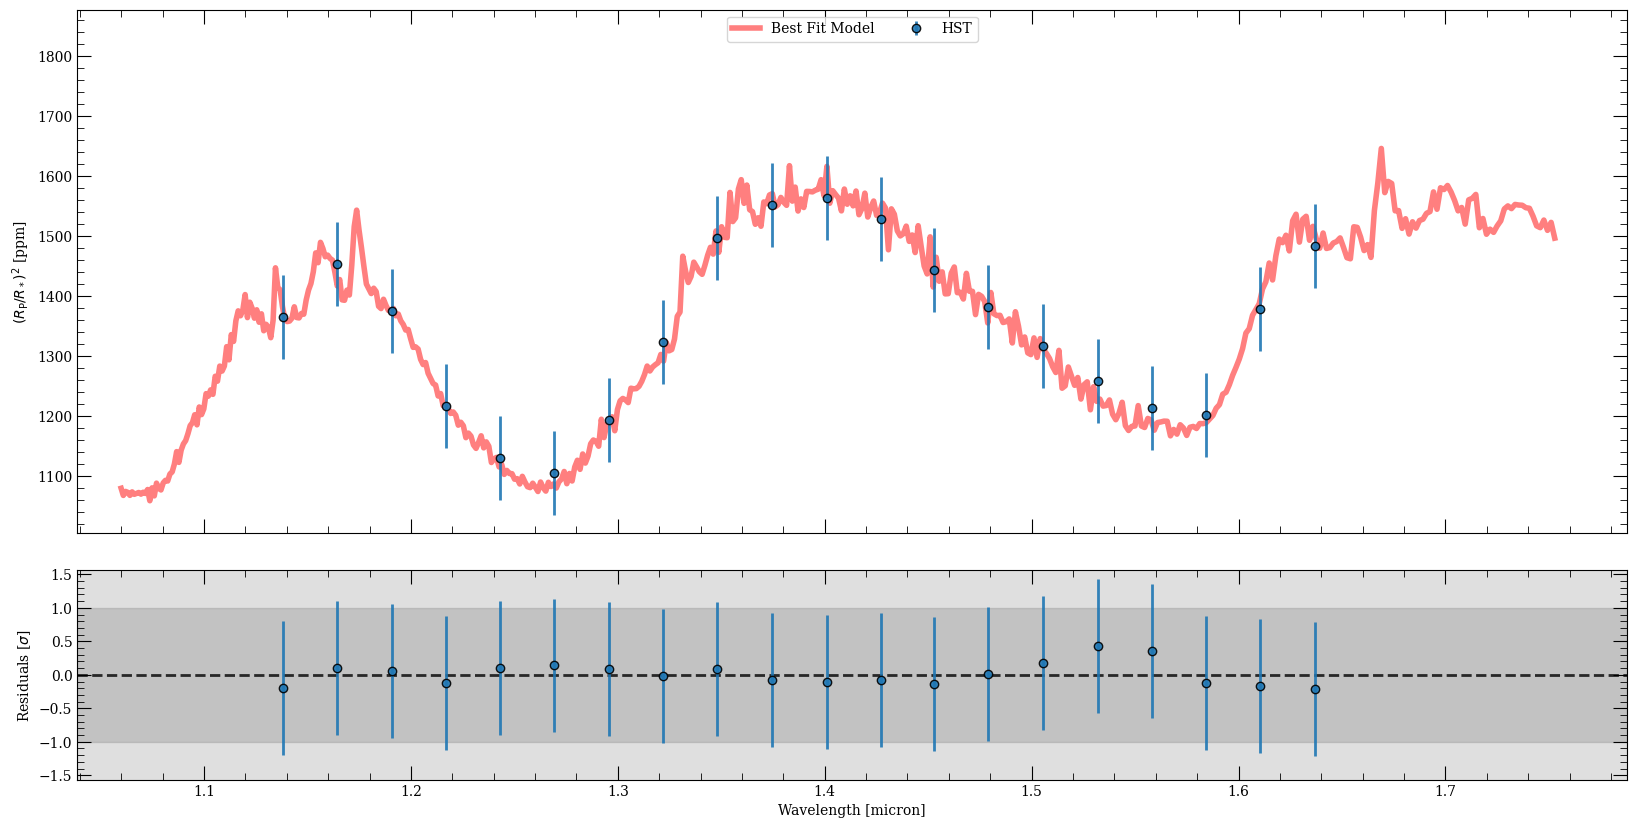

In [ ]:
# Plotting the best fit spectrum
# This will generate a few warnings, but it's fine.
fig,ax,ax_r = retrieval.plot_spectra(samples_use,parameters_read)
plt.show()


Next we want to look at the pressure-temperature profile. Since we used an isothermal model, this is just a vertically constant temperature. The contours represent the 1,2 and 3 $\sigma$ confidence intervals. 

Do you think an isothermal model is a reasonable assumption for a planet? Why or why not? How would you justify using a more complicated model?

Plotting PT profiles


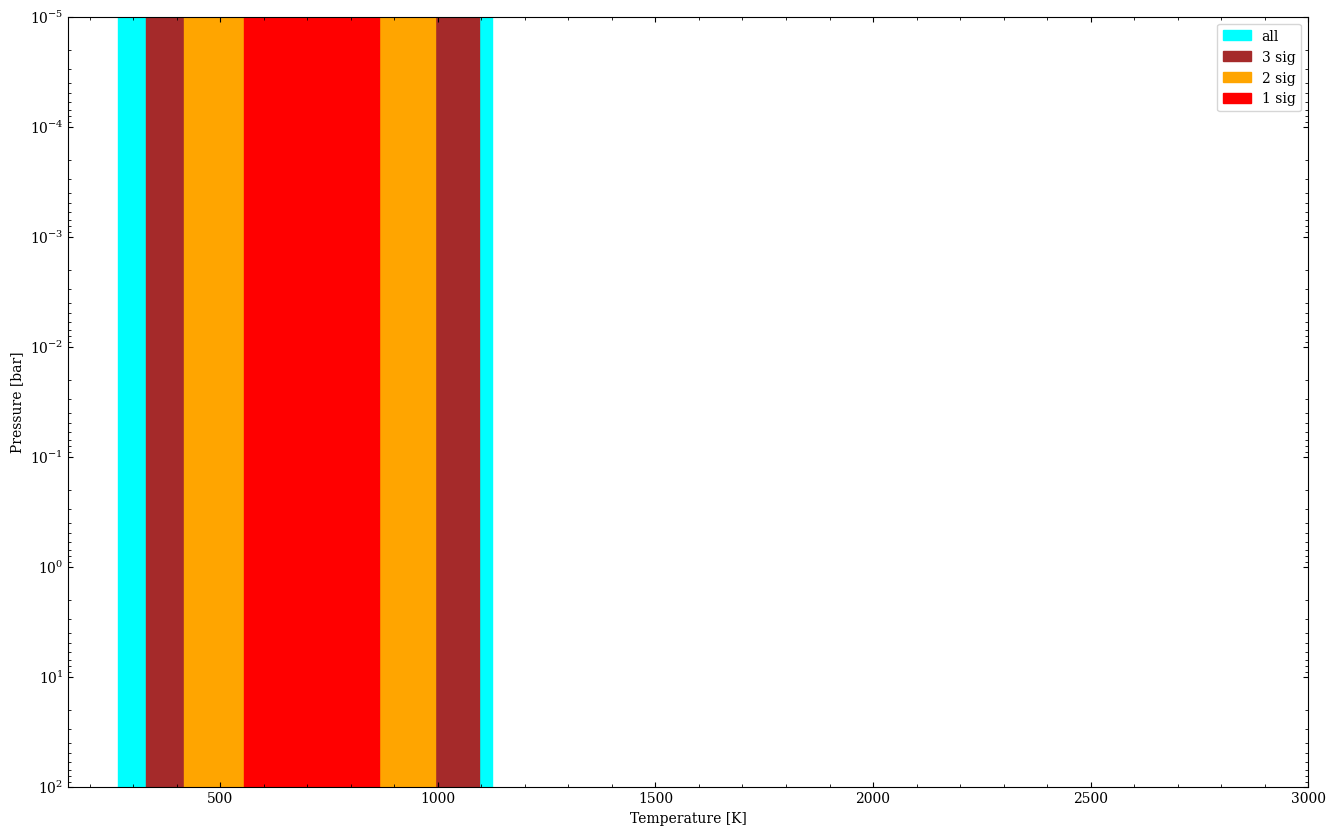

In [ ]:
# Plotting the PT profile
fig,ax =retrieval.plot_PT(sample_dict,parameters_read)
plt.show()


Finally, we want to see the distribution of all of the parameters that we retrieved. This gives us statistically meaningful quantities that we can use to make statments about the composition and structure of the planetary atmosphere. It's important to pay attention to parameters with strong correlations. Some of them are straightforward to explain: for example, the radius and temperature will be strongly correlated due to the Stephan-Boltzmann Law. Others require more thought - can you think of parameters that could be correlated, and why?

Making corner plot
6


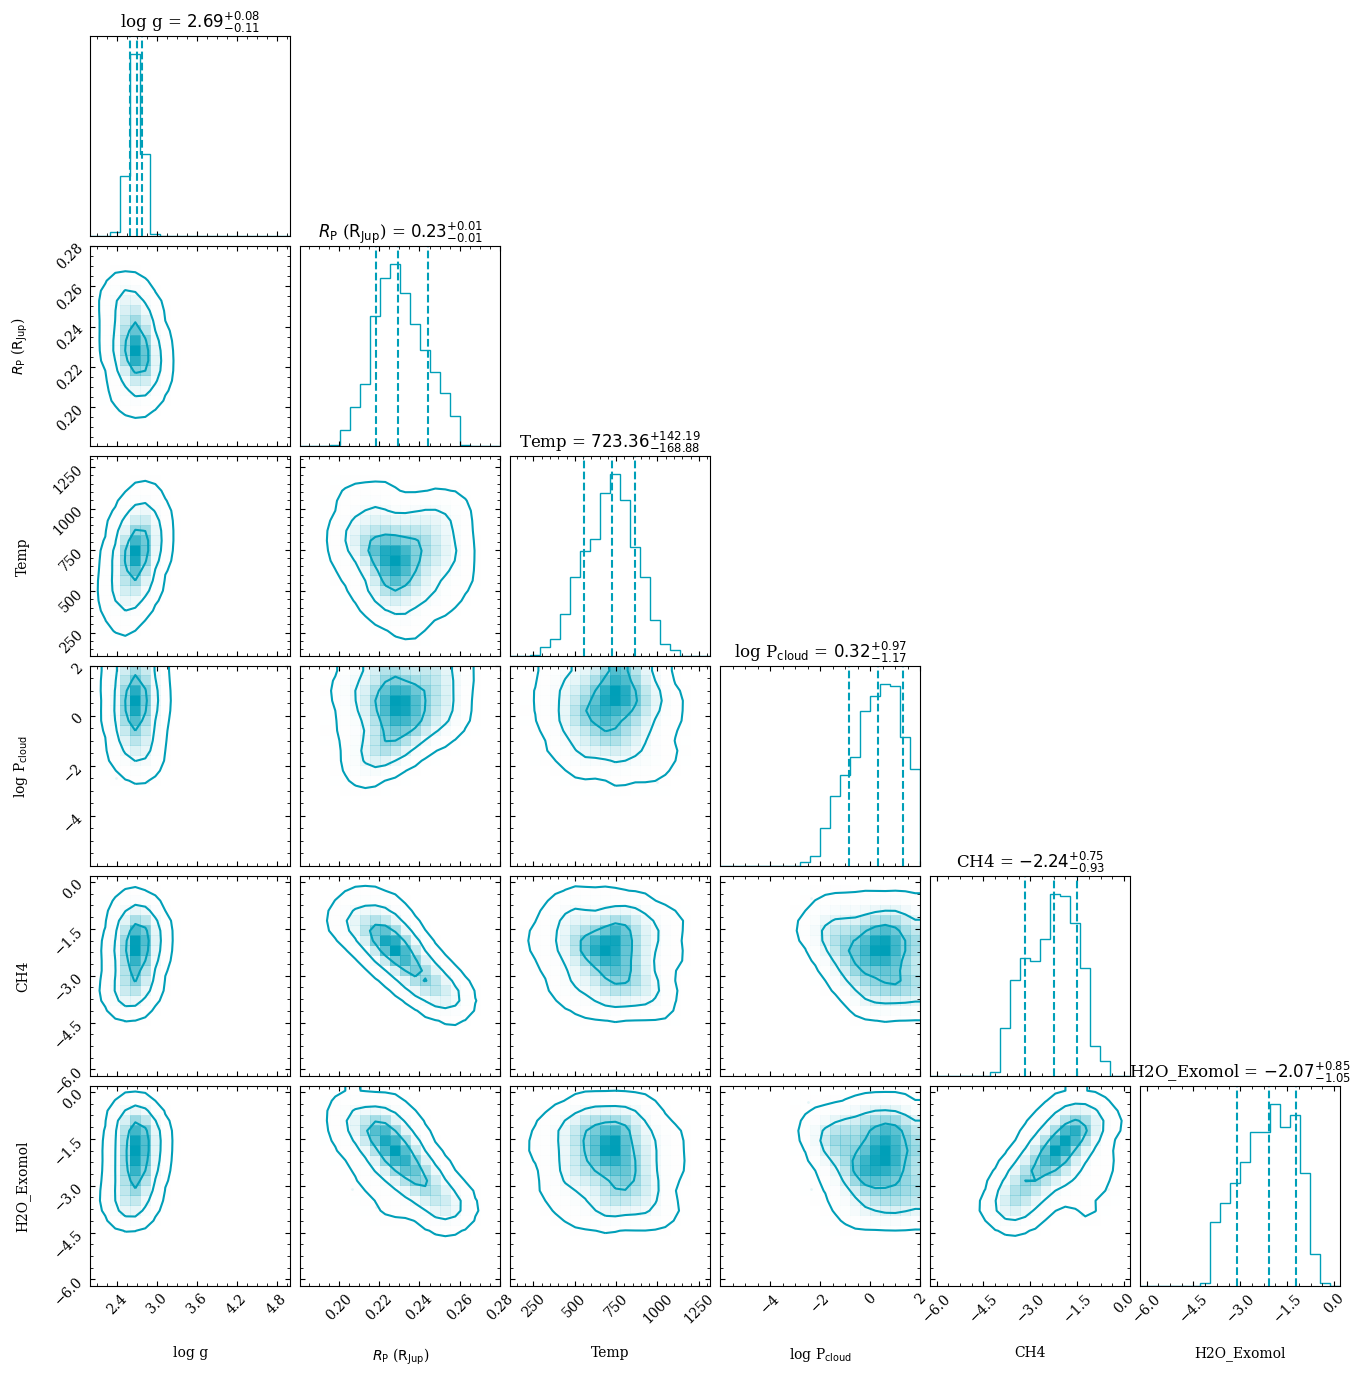

In [ ]:
# Corner plot
# The corner plot produces 1,2 and 3 sigma contours for the 2D plots
retrieval.plot_corner(sample_dict,parameter_dict,parameters_read)
plt.show()

Congratulations! You've made it through the lecture. A few points of discussion before we go - feel free to discuss these during the lecture or on slack afterwards.

1) What are the limitations of retrieval methods? Are there ways we can improve them - what are the factors that limit their accuracy today?

2) How do retrievals compare to the sort of grid fits as discussed in the direct imaging spectroscopy lecture?